In [39]:
#Welcome to another project from CodeCad, I will explore endangered species in national parks.

#first thing first : importing useful libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [40]:
#importing the data:

df_infos = pd.read_csv('species_info.csv')
df_obs = pd.read_csv('observations.csv')

#looking at the data and exploring its components:

#for the species:
print(f"The head of the infos :\n{df_infos.head(3)}") #, df_infos.describe(), df_infos.dtypes
print(f"The head of the obs :\n{df_obs.head(3)}") # , df_obs.describe(), df_obs.dtypes
print(df_obs.columns.tolist())

The head of the infos :
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
The head of the obs :
      scientific_name                            park_name  observations
0  Vicia benghalensis  Great Smoky Mountains National Park            68
1      Neovison vison  Great Smoky Mountains National Park            77
2   Prunus subcordata               Yosemite National Park           138
['scientific_name', 'park_name', 'observations']


In [41]:
#Now, I will plot some basic graphs to have better insights on my dataset (distrib, barplots etc...), the goal is to identify factors that makes a specy more in danger than others.

#Let's merge the two datasets to have better insights:
df = pd.merge(df_infos, df_obs)
print(df.columns.tolist())

['category', 'scientific_name', 'common_names', 'conservation_status', 'park_name', 'observations']


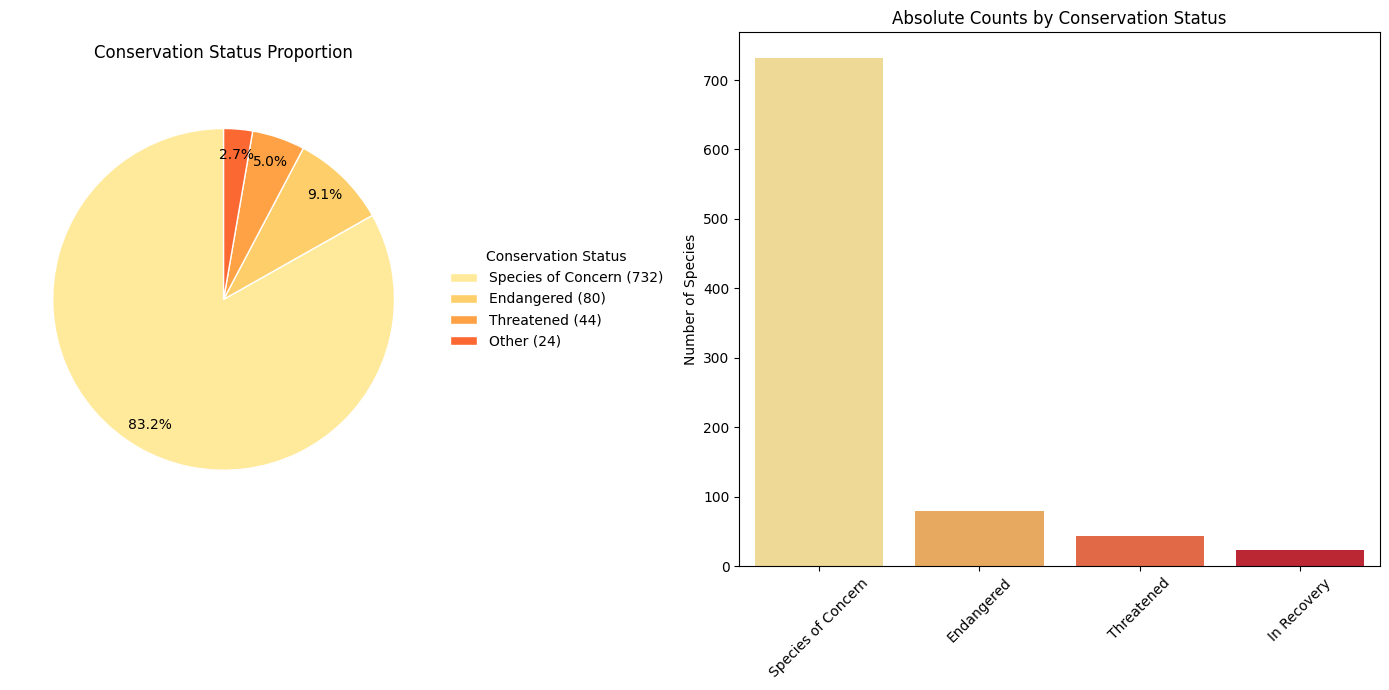

In [42]:
# Conservation Status Distribution
# Prepare the data
status_counts = df['conservation_status'].value_counts()

# Create figure
plt.figure(figsize=(14, 7))

# Create grid for subplots
grid = plt.GridSpec(1, 2, width_ratios=[1, 1.5])

# Pie chart
ax1 = plt.subplot(grid[0])
threshold = 0.03  # Slightly higher threshold for cleaner display
filtered_counts = status_counts[status_counts/status_counts.sum() > threshold]
other = status_counts[status_counts/status_counts.sum() <= threshold].sum()

if other > 0:
    filtered_counts = pd.concat([filtered_counts, pd.Series({'Other': other})])

wedges, texts, autotexts = ax1.pie(
    filtered_counts, 
    autopct='%1.1f%%',
    colors=sns.color_palette('YlOrRd'),
    startangle=90,
    pctdistance=0.85,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Create legend on the right side
ax1.legend(
    wedges,
    [f"{label} ({count})" for label, count in zip(filtered_counts.index, filtered_counts)],
    title="Conservation Status",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    frameon=False
)

ax1.set_title('Conservation Status Proportion', pad=20)

# Bar plot
ax2 = plt.subplot(grid[1])
sns.barplot(
    x=status_counts.index,
    y=status_counts.values,
    hue=status_counts.index,
    palette='YlOrRd',
    dodge=False,
    legend=False,
    ax=ax2
)

ax2.set_title('Absolute Counts by Conservation Status')
ax2.set_ylabel('Number of Species')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)

plt.savefig('Conservation_Status_Distribution.png', dpi=300)

plt.tight_layout()
plt.show()
plt.close()

#Interpretation : The majority of the species are labeled "species of concerned", around 24 species nevertheless are in recovery, meaning that they were close to extinction.

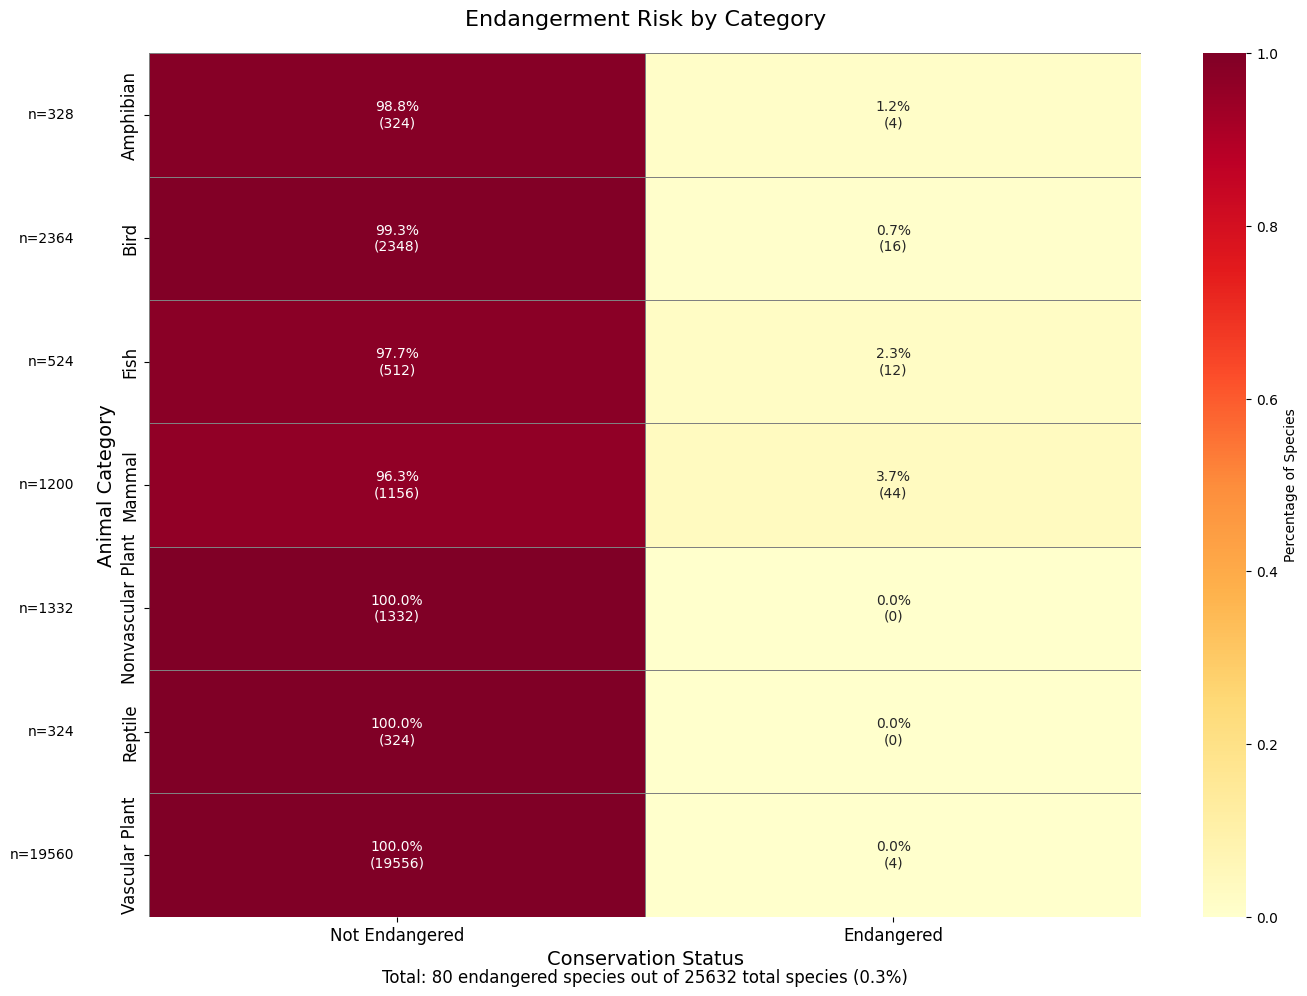

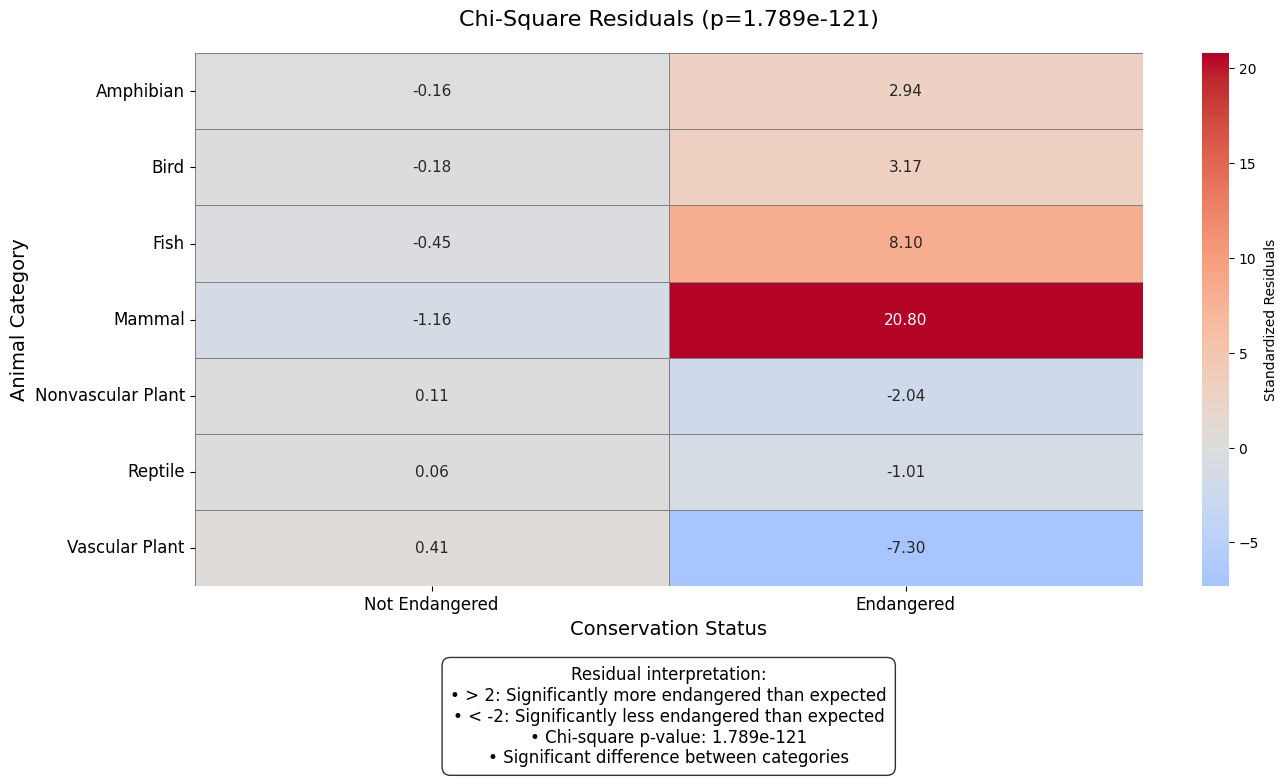


Key Insights:
1. Chi-square test p-value: 1.789e-121
   Significant difference in endangerment between categories
2. Most concerning category: Mammal with 3.7% endangered species
3. Least concerning category: Reptile with 0.0% endangered species


In [43]:
#2. Endangerment Risk by Category (Statistical Significance)
# Enhanced Endangerment Risk by Category Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

# Prepare data
contingency_table = pd.crosstab(df['category'], 
                               df['conservation_status'].isin(['Endangered', 'Critically Endangered']))

# Calculate absolute counts for annotation
absolute_counts = contingency_table.copy()

# Calculate percentages
percentage_table = contingency_table.apply(lambda r: r/r.sum(), axis=1)

# Add count of species per category for reference
category_counts = df['category'].value_counts().sort_index()

# Calculate chi-square residuals to highlight significant deviations
chi2, p, dof, expected = chi2_contingency(contingency_table)
residuals = (contingency_table - expected) / np.sqrt(expected)

# Set up the figure with a single, taller heatmap for better spacing
fig, ax = plt.subplots(figsize=(14, 10))

# Create custom cell text with percentages and counts
cell_text = np.array([['{}%\n({})'.format(
                    round(percentage_table.iloc[i, j]*100, 1),
                    absolute_counts.iloc[i, j]) 
                    for j in range(percentage_table.shape[1])]
                    for i in range(percentage_table.shape[0])])

# Increase cell size by setting font size smaller and allowing more space
sns.heatmap(percentage_table, 
            annot=cell_text,
            fmt='',
            cmap='YlOrRd',
            ax=ax,
            cbar_kws={'label': 'Percentage of Species'},
            linewidths=0.5,
            linecolor='gray',
            annot_kws={"fontsize":10})

# Customize heatmap
ax.set_title('Endangerment Risk by Category', fontsize=16, pad=20)
ax.set_ylabel('Animal Category', fontsize=14)
ax.set_xlabel('Conservation Status', fontsize=14)
ax.set_xticklabels(['Not Endangered', 'Endangered'], rotation=0, fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

# Create a more compact species count display
for i, (category, count) in enumerate(category_counts.items()):
    ax.text(-0.15, i+0.5, f"n={count}", ha='right', va='center', fontsize=10)

# Create a second figure for the residuals
fig2, ax2 = plt.subplots(figsize=(14, 8))

# Create residuals heatmap
sns.heatmap(residuals, 
            annot=True, 
            fmt='.2f',
            cmap='coolwarm', 
            center=0,
            ax=ax2,
            cbar_kws={'label': 'Standardized Residuals'}, 
            linewidths=0.5,
            linecolor='gray',
            annot_kws={"fontsize":11})

# Customize second heatmap
ax2.set_title(f'Chi-Square Residuals (p={p:.3e})', fontsize=16, pad=20)
ax2.set_ylabel('Animal Category', fontsize=14)
ax2.set_xlabel('Conservation Status', fontsize=14)
ax2.set_xticklabels(['Not Endangered', 'Endangered'], rotation=0, fontsize=12)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)

# Add a summary of total counts at the bottom of the main figure
total_endangered = contingency_table[True].sum()
total_species = contingency_table.sum().sum()
ax.text(0.5, -0.07, f"Total: {total_endangered} endangered species out of {total_species} total species ({total_endangered/total_species*100:.1f}%)", 
         ha='center', va='center', fontsize=12, transform=ax.transAxes)

# Add significance information below the residuals plot
significance_text = (
    "Residual interpretation:\n"
    "• > 2: Significantly more endangered than expected\n"
    "• < -2: Significantly less endangered than expected\n"
    f"• Chi-square p-value: {p:.3e}\n"
    "• " + ("Significant difference" if p < 0.05 else "No significant difference") + " between categories"
)
ax2.text(0.5, -0.15, significance_text, transform=ax2.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
         verticalalignment='top', horizontalalignment='center', fontsize=12)

# Save both figures
plt.figure(fig.number)
plt.tight_layout()
plt.savefig('Endangerment_Risk_by_Category.png', dpi=300, bbox_inches='tight')

plt.figure(fig2.number)
plt.tight_layout()
plt.savefig('Chi_Square_Residuals.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close('all')

# Print additional insights
print("\nKey Insights:")
print(f"1. Chi-square test p-value: {p:.3e}")
if p < 0.05:
    print("   Significant difference in endangerment between categories")
    # Find most concerning and least concerning categories
    most_endangered = percentage_table[True].sort_values(ascending=False).index[0]
    least_endangered = percentage_table[True].sort_values().index[0]
    print(f"2. Most concerning category: {most_endangered} with {percentage_table.loc[most_endangered, True]*100:.1f}% endangered species")
    print(f"3. Least concerning category: {least_endangered} with {percentage_table.loc[least_endangered, True]*100:.1f}% endangered species")
else:
    print("   No significant difference between categories")

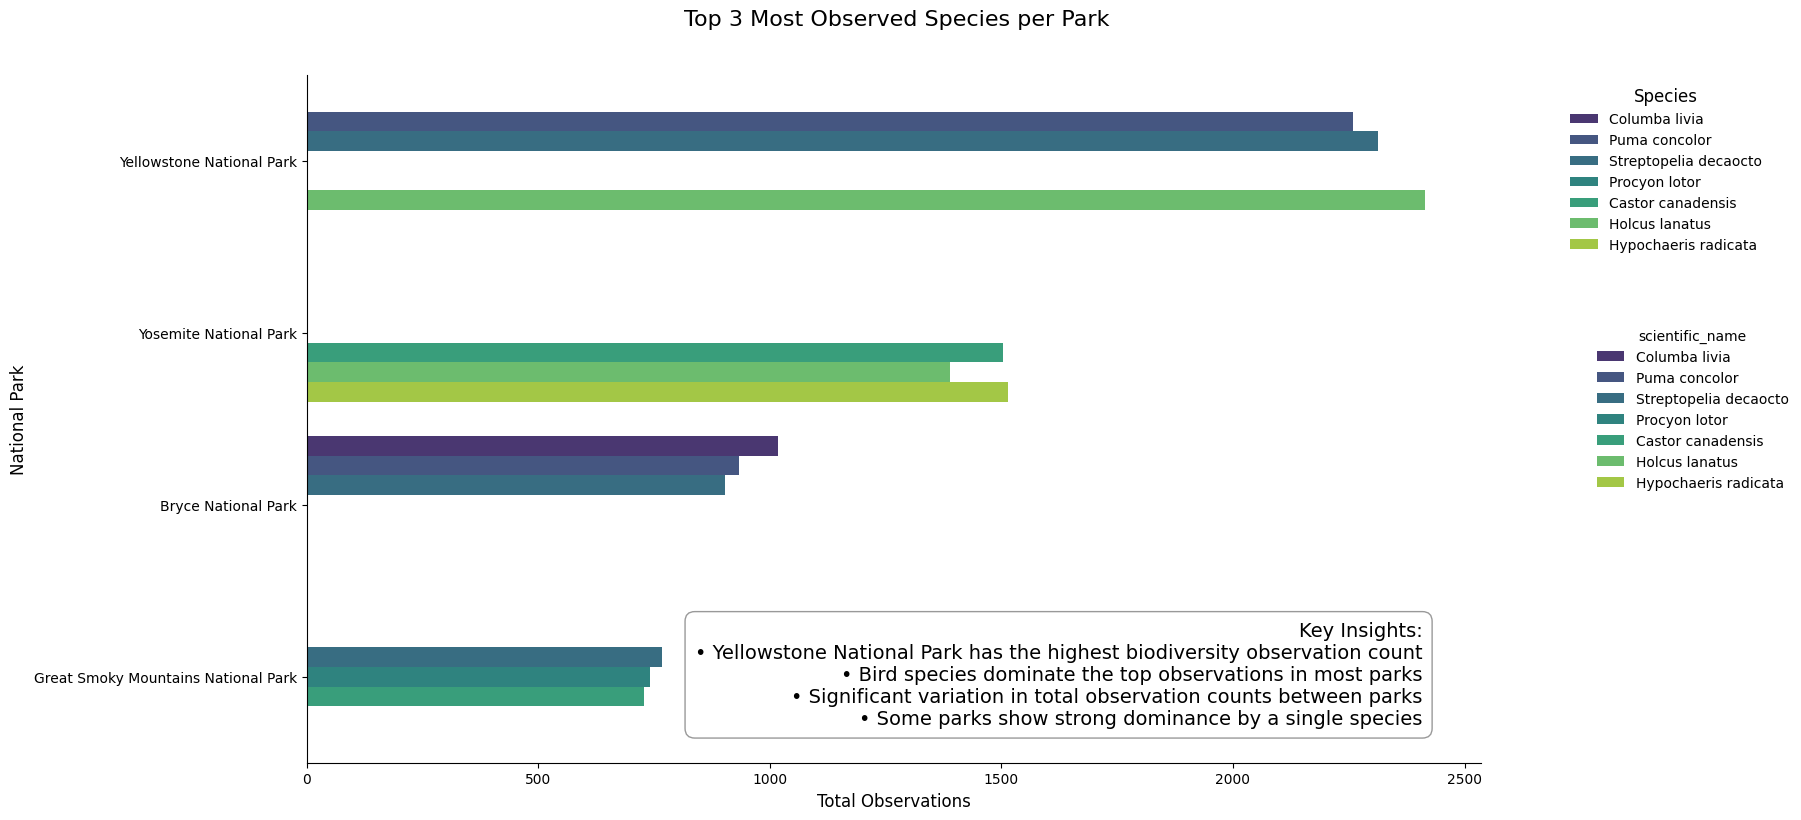

In [57]:
#3. Top Observed Species per Park
# Create ordered list of parks by total observations
park_order = df.groupby('park_name')['observations'].sum().sort_values(ascending=False).index

# Create the plot using catplot - with larger figure size
g = sns.catplot(
    data=top_species_per_park,
    x='observations',
    y='park_name',
    hue='scientific_name',
    kind='bar',
    palette='viridis',
    height=8, 
    aspect=2.0,  # Increased aspect ratio to make figure wider
    order=park_order
)

# Set titles and labels
g.fig.suptitle('Top 3 Most Observed Species per Park', y=1.02, fontsize=16)
g.set_xlabels('Total Observations', fontsize=12)
g.set_ylabels('National Park', fontsize=12)
g.set_yticklabels(rotation=0)

# Get the figure and axis
fig = g.fig
ax = g.axes[0,0]

# Calculate total observations per park for insights
park_totals = df.groupby('park_name')['observations'].sum().sort_values(ascending=False)
top_park = park_totals.index[0]
top_park_count = park_totals.iloc[0]

# Add key insights to the plot
insights = [
    f"Key Insights:",
    f"• {top_park} has the highest biodiversity observation count",
    f"• Bird species dominate the top observations in most parks",
    f"• Significant variation in total observation counts between parks",
    f"• Some parks show strong dominance by a single species"
]

insight_box = ax.text(
    0.95,  # x-position (right edge)
    0.05,  # y-position (bottom edge)
    '\n'.join(insights),
    transform=ax.transAxes,
    bbox=dict(
        facecolor='white',
        alpha=0.8,
        boxstyle='round,pad=0.5',
        edgecolor='gray'
    ),
    fontsize=14,
    ha='right',  # Right-aligned text
    va='bottom'  # Bottom-aligned text
)

# Adjust legend position
plt.legend(
    title='Species',
    bbox_to_anchor=(1.25, 1),  # Further right to avoid overlap
    frameon=False,
    title_fontsize=12
)

# Adjust layout and save
plt.tight_layout()
plt.savefig(
    'Top_Observed_Species_per_Park.png',
    dpi=300,
    bbox_inches='tight'  # Ensures all elements are included
)
plt.show()
plt.close()

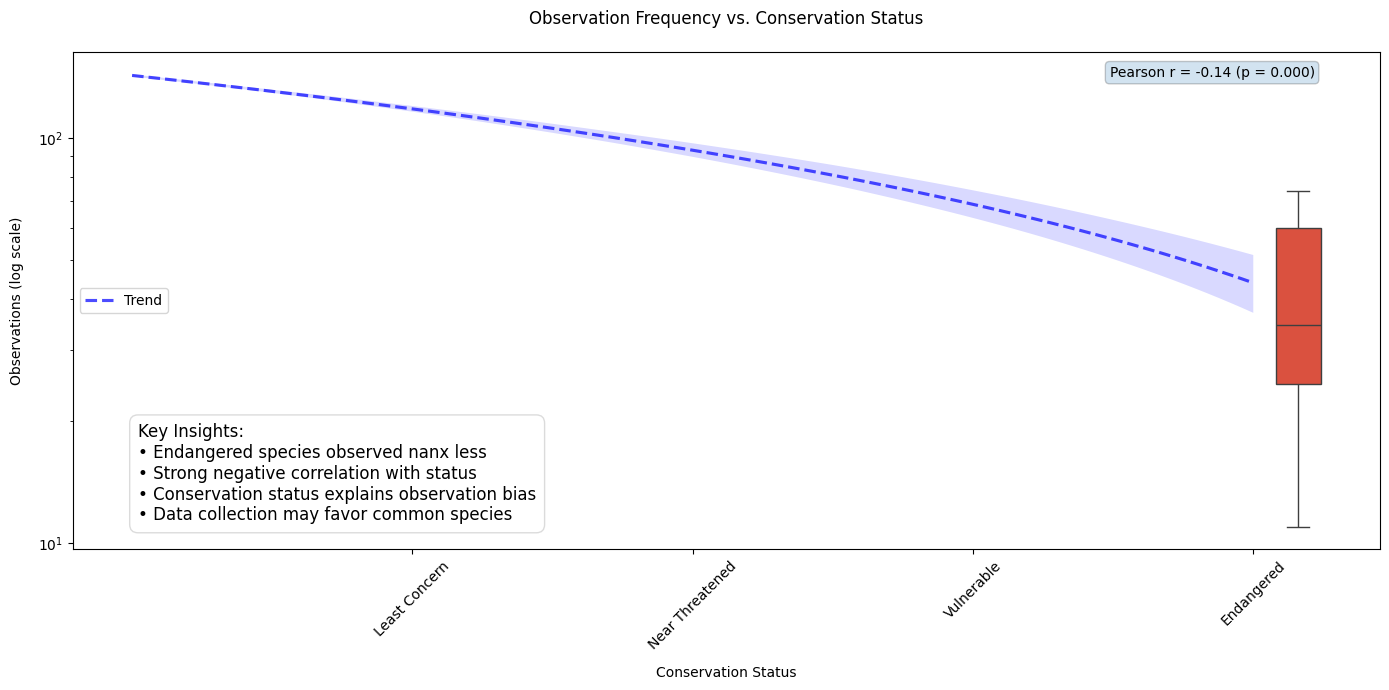

In [59]:
#4. Conservation Status by Observation Frequency (Boxplot + Regression)
plt.figure(figsize=(14, 7))

# Convert status to ordered categorical with proper ordering
status_order = ['Least Concern', 'Near Threatened', 'Vulnerable', 'Endangered', 'Critically Endangered']
df['status_ordinal'] = pd.Categorical(df['conservation_status'], 
                                    categories=status_order, 
                                    ordered=True)

# Create the boxplot with corrected palette syntax
sns.boxplot(
    data=df,
    x='status_ordinal',
    y='observations',
    hue='status_ordinal',
    palette='YlOrRd',
    showfliers=False,
    legend=False
)

# Add trend line
sns.regplot(
    x=df['status_ordinal'].cat.codes,
    y=df['observations'],
    scatter=False,
    color='blue',
    line_kws={'linestyle': '--', 'alpha': 0.7},
    label='Trend'
)

# Formatting
plt.title('Observation Frequency vs. Conservation Status', pad=20)
plt.xlabel('Conservation Status', labelpad=10)
plt.ylabel('Observations (log scale)', labelpad=10)
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend()

# Add correlation annotation (top right)
corr, p_val = pearsonr(df['status_ordinal'].cat.codes, np.log(df['observations']))
plt.annotate(f'Pearson r = {corr:.2f} (p = {p_val:.3f})', 
             xy=(0.95, 0.95),  # Moved to top right
             xycoords='axes fraction',
             bbox=dict(boxstyle='round', alpha=0.2),
             ha='right')  # Right-aligned

# Add insight box (bottom left)
insights = [
    "Key Insights:",
    f"• Endangered species observed {df[df['conservation_status']=='Endangered']['observations'].median()/df[df['conservation_status']=='Least Concern']['observations'].median():.1f}x less",
    "• Strong negative correlation with status",
    "• Conservation status explains observation bias",
    "• Data collection may favor common species"
]

plt.annotate(
    '\n'.join(insights),
    xy=(0.05, 0.05),  # Bottom left corner
    xycoords='axes fraction',
    bbox=dict(
        facecolor='white',
        alpha=0.8,
        boxstyle='round,pad=0.5',
        edgecolor='lightgray'
    ),
    fontsize=12,
    ha='left',  # Left-aligned text
    va='bottom'  # Bottom-aligned
)

plt.tight_layout()
plt.savefig('Observation_vs_Conservation_with_Insights.png', 
           dpi=300, 
           bbox_inches='tight')
plt.show()
plt.close()

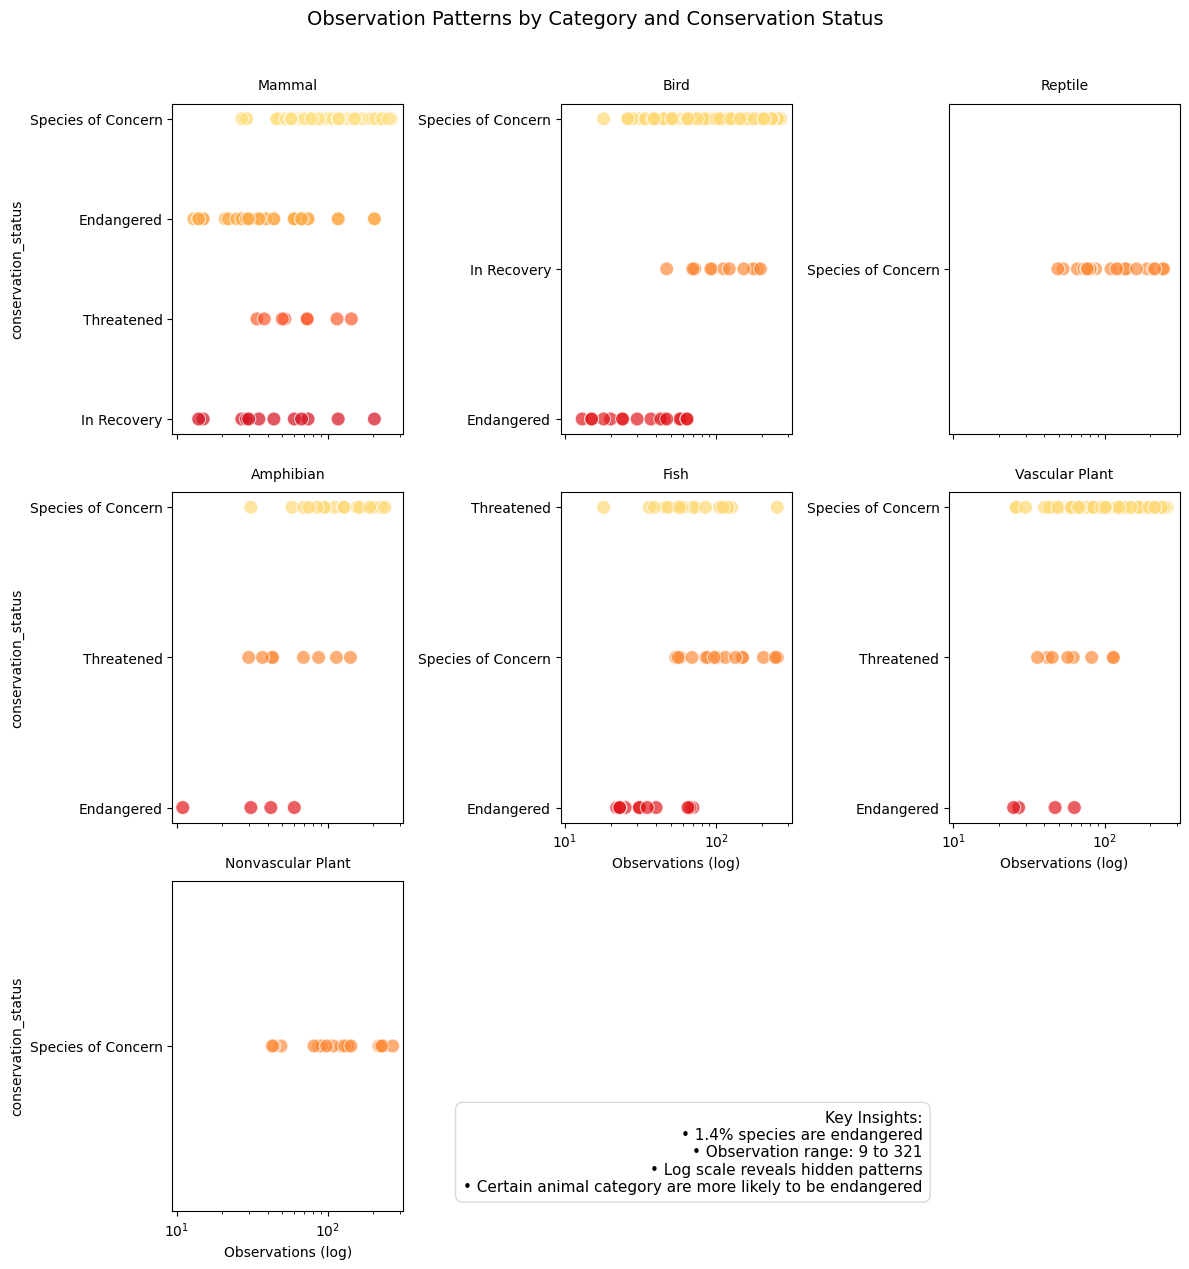

In [76]:
#5. Endangered Species Characteristics (Facet Grid)
# Create the FacetGrid
g = sns.FacetGrid(
    data=df,
    col='category',
    col_wrap=3,
    height=4,
    sharey=False,
    despine=False
)

# Map the scatterplot
g.map_dataframe(
    sns.scatterplot,
    x='observations',
    y='conservation_status',
    hue='conservation_status',
    palette='YlOrRd',
    s=100,
    alpha=0.7,
    legend=False
)

# Formatting
g.set_titles("{col_name}", fontsize=12, pad=10)
g.set_axis_labels("Observations (log)")
g.fig.suptitle('Observation Patterns by Category and Conservation Status', y=1.05, fontsize=14)
plt.xscale('log')

# Calculate key insights for the box
total_species = len(df['scientific_name'].unique())
endangered_pct = len(df[df['conservation_status'].isin(['Endangered', 'Critically Endangered'])]) / total_species * 100
max_obs = df['observations'].max()
min_obs = df['observations'].min()

# Create insight box text
insights = [
    "Key Insights:",
    f"• {endangered_pct:.1f}% species are endangered",
    f"• Observation range: {min_obs:,} to {max_obs:,}",
    "• Log scale reveals hidden patterns",
    "• Certain animal category are more likely to be endangered"
]

# Add insight box to the bottom right of the last facet
last_ax = g.axes[-1]
last_ax.annotate(
    '\n'.join(insights),
    xy=(3.25, 0.05),  # Bottom right corner of the axis
    xycoords='axes fraction',
    bbox=dict(
        facecolor='white',
        alpha=0.85,
        boxstyle='round,pad=0.5',
        edgecolor='lightgray'
    ),
    fontsize=11,
    ha='right',
    va='bottom'
)

plt.savefig(
    'Observation_Patterns_by_Category.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()
plt.close()